# 1. Importacion de librerias

Se cargan las librerías necesarias para análisis estadístico, visualización, preprocesamiento, construcción del modelo, y reducción de dimensionalidad. Se incluyen scikit-learn para tareas de machine learning supervisado, pandas para manipulación de datos, matplotlib y seaborn para visualización, y UMAP para proyecciones no lineales.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import umap.umap_ as umap

# 2. Carga y preparación de los datos clínicos

Se importa un conjunto de datos estructurado con 1000 registros de pacientes gestantes, incluyendo variables clínicas y psicosociales, además de la categoría de riesgo (bajo, moderado, alto). Las variables binarias son transformadas a formato numérico (1: Sí, 0: No), y la variable objetivo (Riesgo_Biopsicosocial) es codificada con preservación del orden clínico.

In [2]:
df = pd.read_excel("/content/drive/MyDrive/IA Salud/Base_Riesgo_Materno_Infantil_1000_Registros.xlsx")

# Asegurar orden de categorías
df["Riesgo_Biopsicosocial"] = pd.Categorical(df["Riesgo_Biopsicosocial"], categories=["Bajo", "Moderado", "Alto"], ordered=True)

# Transformar datos
X = df.drop(columns=["ID_Paciente", "Riesgo_Biopsicosocial"])
X = X.applymap(lambda x: 1 if x == "Sí" else 0)
y = LabelEncoder().fit_transform(df["Riesgo_Biopsicosocial"])


<ipython-input-2-f23d5d944add>:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: 1 if x == "Sí" else 0)


# 3. 3. División y configuración de GridSearchCV

El dataset es dividido en un conjunto de entrenamiento (80%) y otro de validación (20%), manteniendo la proporción de clases (estratificación). Se define una rejilla de hiperparámetros del modelo Random Forest, contemplando: número de árboles, profundidad máxima, tamaño mínimo de nodos, y balance de clases, con el objetivo de controlar sobreajuste y mejorar generalización. Se emplea GridSearchCV combinado con StratifiedKFold (k=5) para realizar una validación cruzada robusta. Este enfoque evalúa sistemáticamente múltiples combinaciones de hiperparámetros, asegurando que cada fold de entrenamiento mantenga la distribución real de clases. La métrica de evaluación principal es el F1-score macro, ideal para problemas multiclase con riesgo clínico desigual.

In [3]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'class_weight': ['balanced']
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=cv,
                           scoring='f1_macro', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


# 4. Evaluación y matriz de confusión

El mejor modelo identificado por GridSearchCV se evalúa sobre el conjunto de validación independiente. Se analiza el rendimiento mediante el reporte de clasificación (precisión, recall, F1-score por clase) y la matriz de confusión. Este análisis permite interpretar no solo la eficacia global del modelo, sino también su sensibilidad específica para identificar casos de alto riesgo clínico.

🔍 Mejores hiperparámetros: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

📋 Reporte de clasificación (modelo ajustado):
              precision    recall  f1-score   support

        Bajo       0.95      0.69      0.80        58
    Moderado       0.84      1.00      0.92        65
        Alto       0.78      0.82      0.80        77

    accuracy                           0.84       200
   macro avg       0.86      0.84      0.84       200
weighted avg       0.85      0.84      0.84       200



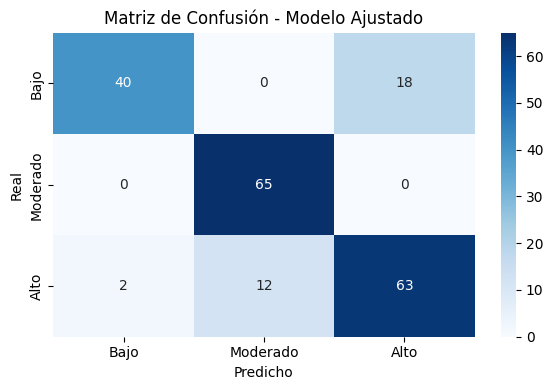

In [4]:
print("🔍 Mejores hiperparámetros:", grid_search.best_params_)
print("\n📋 Reporte de clasificación (modelo ajustado):")
print(classification_report(y_val, y_pred_val, target_names=df["Riesgo_Biopsicosocial"].cat.categories))

cm = confusion_matrix(y_val, y_pred_val)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df["Riesgo_Biopsicosocial"].cat.categories,
            yticklabels=df["Riesgo_Biopsicosocial"].cat.categories)
plt.title("Matriz de Confusión - Modelo Ajustado")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.tight_layout()
plt.show()


# 5. Visualización de relaciones clínicas clave

Se emplean gráficos de dispersión para analizar la distribución del riesgo frente a variables de interés clínico como la edad materna y las semanas de gestación. Esta exploración permite identificar patrones clínicamente significativos y confirmar que el modelo no depende exclusivamente de una sola variable.

<ipython-input-5-f5748d8ef05e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="Riesgo_Biopsicosocial", y="Semanas_Gestacion", jitter=0.25, alpha=0.6,
<ipython-input-5-f5748d8ef05e>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x="Riesgo_Biopsicosocial", y="Edad", jitter=0.25, alpha=0.6,


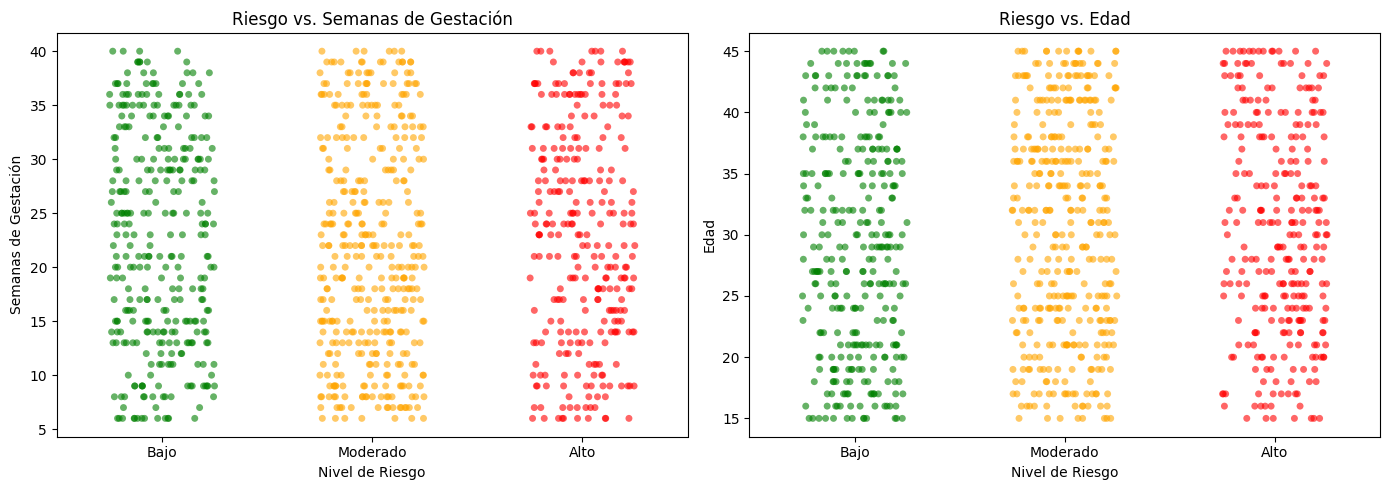

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.stripplot(data=df, x="Riesgo_Biopsicosocial", y="Semanas_Gestacion", jitter=0.25, alpha=0.6,
              palette={"Bajo": "green", "Moderado": "orange", "Alto": "red"}, ax=axes[0])
axes[0].set_title("Riesgo vs. Semanas de Gestación")
axes[0].set_ylabel("Semanas de Gestación")

sns.stripplot(data=df, x="Riesgo_Biopsicosocial", y="Edad", jitter=0.25, alpha=0.6,
              palette={"Bajo": "green", "Moderado": "orange", "Alto": "red"}, ax=axes[1])
axes[1].set_title("Riesgo vs. Edad")
axes[1].set_ylabel("Edad")

for ax in axes:
    ax.set_xlabel("Nivel de Riesgo")

plt.tight_layout()
plt.show()


# 7. Reducción de dimensionalidad con PCA

Se aplica Análisis de Componentes Principales (PCA) para visualizar los datos en un espacio de dos dimensiones principales. Aunque útil para explorar la estructura de los datos, el solapamiento entre clases indica que la separación lineal es limitada, lo cual justifica el uso de modelos no lineales.



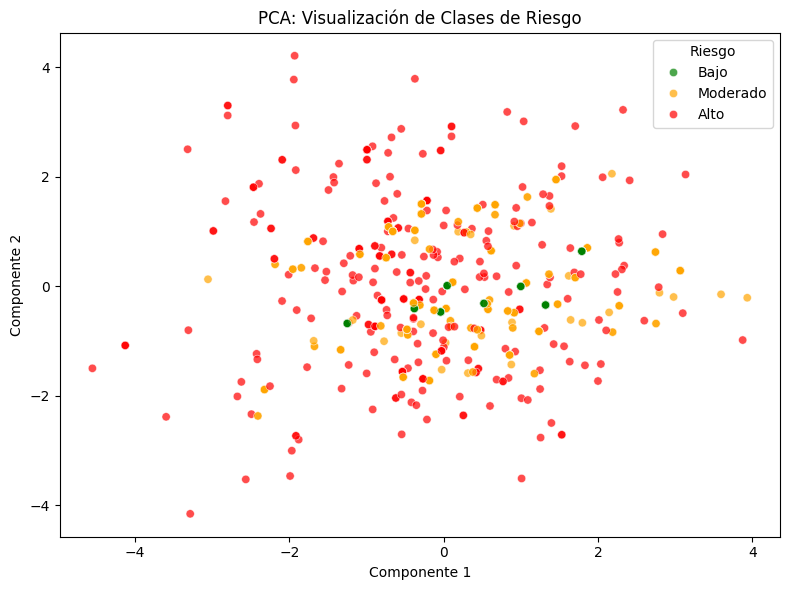

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["Componente 1", "Componente 2"])
pca_df["Riesgo"] = df["Riesgo_Biopsicosocial"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x="Componente 1", y="Componente 2", hue="Riesgo",
                palette={"Bajo": "green", "Moderado": "orange", "Alto": "red"}, alpha=0.7)
plt.title("PCA: Visualización de Clases de Riesgo")
plt.tight_layout()
plt.show()


# 8. Visualización de varianza acumulada (Scree Plot)

Se genera un scree plot que muestra cuántos componentes principales son necesarios para explicar el 70–90% de la varianza. Se observa que se requieren más de 6 componentes para capturar adecuadamente la estructura de los datos, lo que refuerza la naturaleza multivariada del fenómeno clínico.

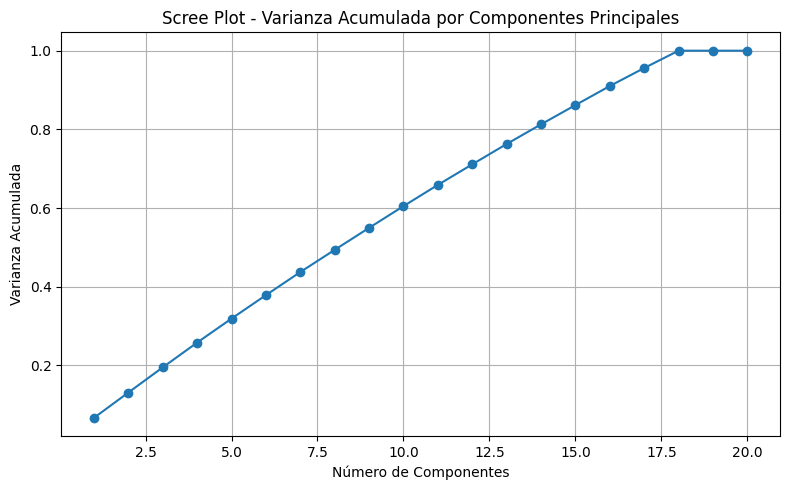

In [7]:
pca_full = PCA().fit(X_scaled)
varianza_acumulada = pca_full.explained_variance_ratio_.cumsum()

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(varianza_acumulada)+1), varianza_acumulada, marker='o', linestyle='-')
plt.title("Scree Plot - Varianza Acumulada por Componentes Principales")
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Acumulada")
plt.grid(True)
plt.tight_layout()
plt.show()


# 9. Proyección no lineal con UMAP

Se emplea UMAP para representar los datos en dos dimensiones, preservando la estructura no lineal tanto local como global. Esta técnica muestra agrupamientos parciales por clase, confirmando que existen estructuras complejas en los datos que pueden ser aprovechadas por modelos avanzados como Random Forest.



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


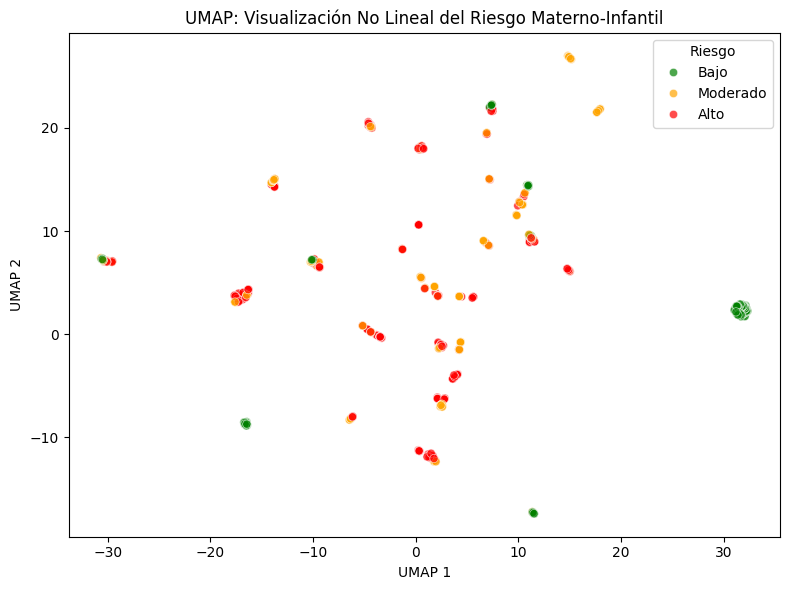

In [8]:
reductor = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = reductor.fit_transform(X_scaled)

umap_df = pd.DataFrame(X_umap, columns=["UMAP 1", "UMAP 2"])
umap_df["Riesgo"] = df["Riesgo_Biopsicosocial"]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x="UMAP 1", y="UMAP 2", hue="Riesgo",
                palette={"Bajo": "green", "Moderado": "orange", "Alto": "red"}, alpha=0.7)
plt.title("UMAP: Visualización No Lineal del Riesgo Materno-Infantil")
plt.tight_layout()
plt.show()
